In [1]:
import numpy as np
import math
from sklearn.datasets import load_iris, load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Gaussowski Naiwny Klasyfikator Bayesa

In [2]:
class NaiveBayesClassifier:
    
    def separate_classes(self, X, y):
        classes, cls_count = np.unique(y, return_counts=True)
        self.classes = classes
        self.length_y = len(y)
        self.class_freq = dict(zip(classes, cls_count))
        classes_indices = {}
        rows = {}
        for dataset_class in classes:
            classes_indices[dataset_class] = y.index[y == dataset_class].tolist()
            rows[dataset_class] = X.loc[classes_indices[dataset_class]]
        self.rows = rows
    
    
    def summarize_dataset(self, X):
        summaries = [(np.mean(X.loc[:,column]), np.std(X.loc[:,column]), column) for column in X.columns]
        return summaries
            
    
    def fit(self, X, y):
        self.means = {}
        self.std = {}
        
        self.separate_classes(X, y)
        for class_type in self.classes:
            summ = self.summarize_dataset(self.rows[class_type])
            self.means[class_type] = [summar[0] for summar in summ]
            self.std[class_type] = [summar[1] for summar in summ]
        
    
    def calculate_probability(self, x, mean, stdev):
        exponent = math.exp(-((x - mean) ** 2 / (2 * stdev ** 2)))
        return (1 / (math.sqrt(2 * math.pi) * stdev ** 2)) * exponent
    
    
    def predict_proba(self, X):
        class_prob = {}
        for cls in self.classes:
            class_prob[cls] = 1
            for i in range(len(self.means[cls])):
                class_prob[cls] *= self.calculate_probability(X[i], self.means[cls][i], self.std[cls][i])
            class_prob[cls] = class_prob[cls] * (self.class_freq[cls] / self.length_y)
        return class_prob
    
    
    def predict(self, X):
        pred = []
        for x in X.values:
            pred_class = None
            max_prob = 0
            for cls, prob in self.predict_proba(x).items():
                if prob > max_prob:
                    max_prob = prob
                    pred_class = cls
            pred.append(pred_class)
        return pred

## Iris dataset
Przetestuj działanie własnej implementacji klasyfikatora dla zbioru danych Iris
(4 cechy). Zastosuj losowy podział zbioru danych na część trenignową i testową
według proporcji 0.6, 0.4. Powtórz eksperyment 20-krotnie i zmierz średni błąd
klasyfikacji i jego odchylenie standardowe.

In [3]:
sklearn_nb = GaussianNB()
nb_class = NaiveBayesClassifier()

X, y = load_iris(return_X_y=True, as_frame=True)
errors = []
sk_err = []


for _ in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
    
    nb_class.fit(X_train, y_train)
    sklearn_nb.fit(X_train, y_train)

    prediction = nb_class.predict(X_test)
    sk_pred = sklearn_nb.predict(X_test)

    class_error = 1 - accuracy_score(y_test, prediction)
    s_error = 1 - accuracy_score(y_test, sk_pred)

    sk_err.append(s_error)
    errors.append(class_error)
    
print(f'Mean classification error: {np.mean(errors) * 100:.2f} +- {np.std(errors)*100: .2f} (%)')
print(f"Mean classification error skle: {np.mean(sk_err)*100:.2f} +- {np.std(sk_err)*100: .2f} (%)")

Mean classification error: 3.83 +-  1.67 (%)
Mean classification error skle: 4.00 +-  2.44 (%)


Dla porównania użyłam implementację NB ze scikit learna, wyniki wychodzą bardzo zbliżone, czasem lepsza jest moja implementacja, czasem biblioteczna. NB dobrze radzi sobie na zbiorze Iris, błąd jest dość niewielki (w okolicach 5 %).

## Wine dataset
Przetestuj działanie klasyfikatora dla zbioru danych Wine (13 cech) pamiętając
o skalowaniu cech (średnia 0, odchylenie standardowe 1). Jako zbiór testowy wykorzystaj 0.3 dostępnego zbioru danych. Zbadaj wpływ skalowania oraz redukcji
wymiaru za pomocą PCA (do 2D) na średnią dokładność klasyfikacji

In [4]:
X, y = load_wine(return_X_y=True, as_frame=True)

nb_class = NaiveBayesClassifier()
scaler = StandardScaler()
pca = PCA(n_components=2, random_state=0)


def test_wine(nb_class):
    plain_preds = []
    scaled_preds = []
    pca_preds = []
    s_pca_preds = []

    for _ in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

        # without changes
        nb_class.fit(X_train, y_train)
        prediction = nb_class.predict(X_test)
        class_error = 1 - accuracy_score(y_test, prediction)
        plain_preds.append(class_error)

        # scaling
        scaled_train = pd.DataFrame(scaler.fit_transform(X_train))
        scaled_test = pd.DataFrame(scaler.transform(X_test))

        nb_class.fit(scaled_train, y_train.reset_index(drop=True))
        prediction = nb_class.predict(scaled_test)
        class_error = 1 - accuracy_score(y_test, prediction)
        scaled_preds.append(class_error)

        # PCA
        pca_train = pd.DataFrame(pca.fit_transform(X_train))
        pca_test = pd.DataFrame(pca.transform(X_test))

        nb_class.fit(pca_train, y_train.reset_index(drop=True))
        prediction = nb_class.predict(pca_test)
        class_error = 1 - accuracy_score(y_test, prediction)
        pca_preds.append(class_error)
        
        # scaling and PCA
        s_pca_train = pd.DataFrame(pca.fit_transform(scaled_train))
        s_pca_test = pd.DataFrame(pca.transform(scaled_test))
        nb_class.fit(s_pca_train, y_train.reset_index(drop=True))
        prediction = nb_class.predict(s_pca_test)
        class_error = 1 - accuracy_score(y_test, prediction)
        s_pca_preds.append(class_error)

    print(f'Mean classification error:')
    print(f'\tPlain: {np.mean(plain_preds) * 100:.2f} +- {np.std(plain_preds) * 100: .2f}')
    print(f'\tScaled: {np.mean(scaled_preds) * 100:.2f} +- {np.std(scaled_preds) * 100: .2f}')
    print(f'\tPCA: {np.mean(pca_preds) * 100:.2f} +- {np.std(pca_preds) * 100: .2f}')
    print(f'\tScaling and PCA: {np.mean(s_pca_preds) * 100:.2f} +- {np.std(s_pca_preds) * 100: .2f}')

In [5]:
test_wine(nb_class)

Mean classification error:
	Plain: 3.33 +-  3.19
	Scaled: 3.33 +-  3.19
	PCA: 22.41 +-  6.44
	Scaling and PCA: 3.43 +-  2.21


In [6]:
test_wine(sklearn_nb)

Mean classification error:
	Plain: 3.15 +-  1.77
	Scaled: 3.15 +-  1.77
	PCA: 25.56 +-  5.57
	Scaling and PCA: 4.26 +-  2.42


Samo skalowanie w ogóle nie zmienia predykcji (NB jest inwariantny ze względu na skalowanie cech). 
PCA zwiększa błąd klasyfikatora znacznie, NB radzi sobie dobrze z dużą liczbą cech, a zmniejszanie wymiaru może spowodować odrzucenie dyskryminującej cechy, np. z powodu małej wariancji. Ten efekt może być zmniejszony przez wykonanie skalowania przed PCA i w eksperymencie faktycznie jest to lepsze od samego PCA, osiąga wyniki podobne do niezmienionego zbioru danych, zwykle trochę je pogarsza.

# Liniowa Regrasja Bayesowska Online

In [7]:
class BayesianLinearRegression:
    
    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov = np.identity(n_features) * alpha
        
        
    def learn(self, x, y):
        # Update the inverse covariance matrix (
        # Equation 77
        old_cov = np.copy(self.cov)
        self.cov = np.linalg.inv(np.linalg.inv(self.cov) + self.beta * np.outer(x, x))
        
        # Update the mean vector
        # Equation 78
        #
        self.mean = self.cov @ (np.linalg.inv(old_cov) @ self.mean + self.beta * y * x)
        
        return self
    
    
    def predict(self, x):
        # Obtain the predictive mean
        # Equation 62, Equation 80
        y_pred_mean = x @ self.mean
        
        # Obtain the predictive variance
        # Equation 81
        y_pred_var = 1 / self.beta + x @ self.cov @ x.T
        
        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)
    
    
    @property
    def weights_dist(self):
        return stats.multivariate_normal(mean=self.mean, cov=self.cov)

## Boston dataset

Przetestuj działanie metody predict() oraz learn() wywoływanych dla kolejnych
danych treningowych ze zbioru Boston (α = 0.3, β = 1). Jak zmienia się błąd
bezwględny pomiędzy kolejną podaną ceną domu yi a wartością przewidzianą przez
model regresji?

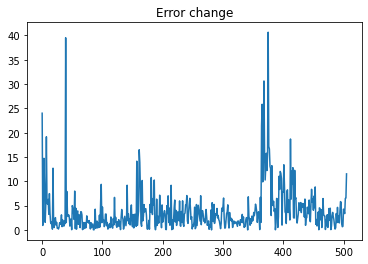

In [8]:
X, y = load_boston(return_X_y=True)

reg = BayesianLinearRegression(n_features=X.shape[1], alpha=0.3, beta=1)

errors = []

for x, y_true in zip(X, y):
    y_pred = reg.predict(x).mean()
    reg.learn(x, y_true)
    
    errors.append(np.abs(y_true - y_pred))
    
plt.title("Error change")
plt.plot(np.arange(len(errors)), errors)
plt.show()

Wygeneruj sztuczny zbiór danych w 2D (10 punktów z przedziału [−1, 1]) zgodnie
ze wzorem t = −0.2 + 0.6x + eps, gdzie eps jest szumem Gaussowskim o średniej 0 i
odchyleniu standardowym 0.2.

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

np.random.seed(8)

def generate(n):
    points = []
    for _ in range(n):
        x = np.random.uniform(-1, 1)
        t = -0.2 + 0.6 * x + np.random.normal(0, .2) 
        points.append((np.array([1, x]), t))
    return points

Zwizualizuj kolejne kroki Liniowej Regresji Bayesowskiej online (β = 25, α = 2)
dla pierwszych 7 punktów ze zbioru danych. Dla każdego kroku i:

a) Narysuj (contourf()) dwuwymiarowy rozkład prior dla wag w1 i w2 modelu
y = w1 + w2x

b) Narysuj (contourf()) dwuwymiarowy rozkład posterior dla wag w1 i w2

c) Narysuj rozkład predykcyjny (predictive mean, predictive interval), prostą t =
−0.2 + 0.6x oraz punkty wykorzystane do budowy rozkładu predykcyjnego.

[ 1.         -0.21273017] -0.3861491031152313
[1.         0.96949887] 0.5316869174382937
[ 1.        -0.9425359] -1.011686331871908
[1.         0.52832026] -0.18970857456002888
[1.         0.87760783] 0.18952561325780568
[ 1.         -0.45970852] -0.8417619666430413
[1.         0.60211177] 0.04148294756965626


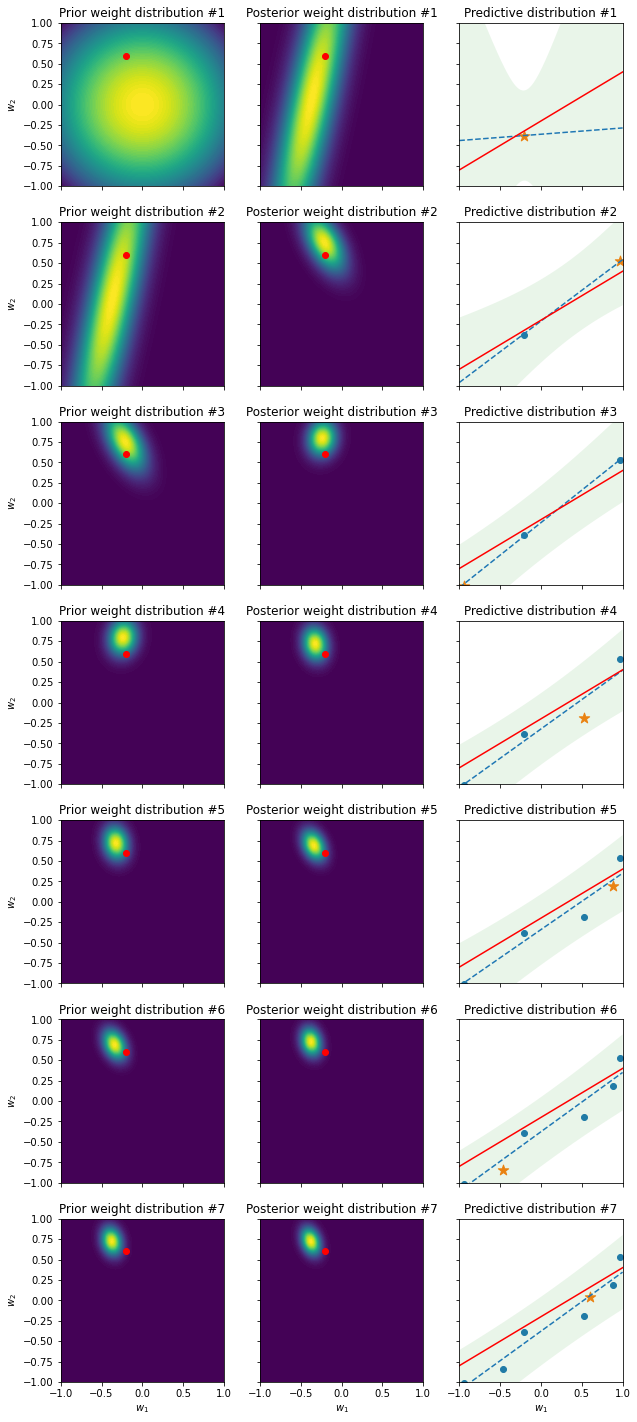

In [11]:
N = 100
w = np.linspace(-1, 1, 100)
W = np.dstack(np.meshgrid(w, w))

fig = plt.figure(figsize=(49, 25))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 3), axes_pad=0.5)

points = generate(10)

weights = np.array([-0.2, 0.6])
model = BayesianLinearRegression(n_features=2, alpha=2, beta=25)

def set_ax(ax):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    return ax

xs = [point[0][1] for point in points]
ys = [point[1] for point in points]

for i, (xi, yi) in enumerate(points[:7]):
    print(xi, yi)
    
    # prior distribution
    ax = set_ax(grid[3 * i])
    ax.set_title(f'Prior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N)
    ax.scatter(*weights, color='red')
    
    # update
    model.learn(xi, yi)
    
    # posterior distribution
    ax = set_ax(grid[3 * i + 1])
    ax.set_title(f'Posterior weight distribution #{i + 1}')
    ax.contourf(w, w, model.weights_dist.pdf(W), N)
    ax.scatter(*weights, color='red')
    
    # predictive distribution
    preds = [model.predict(np.array([1, wi])) for wi in w]
    ax = set_ax(grid[3 * i + 2])
    ax.set_title(f'Predictive distribution #{i + 1}')
    
    ax.scatter([x for x in xs[:i]], ys[:i])
    ax.scatter(xs[i], ys[i], marker='*', s=120)
    
    ax.plot(w, [p.mean() for p in preds], linestyle='--')
    cis = [p.interval(0.95) for p in preds]
    ax.fill_between(
        x=w,
        y1=[ci[0] for ci in cis],
        y2=[ci[1] for ci in cis],
        alpha=0.1
    )
    
    # true target distribution
    ax.plot(w, [-0.2 + 0.6*xi for xi in w], color='red')


Jak zmienia się kształt rozkładu posterior wraz z dodawaniem kolejnych punktów?

Rozkład wag zawęża się, zbliżając się do prawdziwego rozkładu wag (punktu -0.2, 0.6). Niepewności predykcji są też coraz mniejsze.